# Text Normalization using Memory Augmented Neural Networks
---

This notebook and the accompanying paper [Text Normalization using Memory Augmented Neural Networks](https://arxiv.org/?) demonstrates an accuracy of XX.X% on the Text Normalization Challenge by Richard Sproat and Navdeep Jaitly. The approach used here has secured the 6th position in the [Kaggle Russian Text Normalization Challenge](https://www.kaggle.com/c/text-normalization-challenge-russian-language) by Google's Text Normalization Research Group.

# Table of Contents
---
1. [Import Dependencies](#import)
2. [Global Config](#config)
3. [Load Dataset](#load)
4. [XGBoost Classification](#xgb)
5. [Encode Data](#encode)
6. [DNC Normalization](#dnc)
7. [Data Postprocessing](#post)
8. [Results Analysis](#result)
9. [Comparison](#comparison)  
10. [Conclusion](#conclusion)

___

## 1. Import Dependencies
<a id="import"></a>

### Import Libraries

In [28]:
import os
import gc
import sys

import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

from xgboost.sklearn import XGBClassifier

%matplotlib inline

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Utilities

In [30]:
sys.path.append("../src")

from utils import Encoder
from utils import Normalized2String
from XGBclassify import XGB
import DNCnormalize

**System Information**

In [31]:
%load_ext watermark
%watermark -v -n -m -p numpy,pandas,matplotlib,seaborn,sklearn,xgboost,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Tue May 22 2018 

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.21.0
matplotlib 2.1.0
seaborn 0.8.1
sklearn 0.19.1
xgboost 0.6
tensorflow 1.3.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-1015-gcp
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## 2. Global Config
<a id="config"></a>


**Language : English or Russian?**

In [35]:
#lang = 'english'
lang = 'russian'

In [36]:
if lang == 'english':
    # input data
    data_directory = '../data/english/'
    data = data_directory+'output-00099-of-00100_processed.csv'
    vocab = data_directory+'en_vocab.data'
    # interim data
    encoded_file = data_directory+'en_encoded.npy'
    encoded_len_file = data_directory+'en_encoded_len.npy'
    normalized_file = data_directory+'en_normalized.npy'
    # model
    model_directory = '../models/english/'
    xgb_path = model_directory+'en_xgb_tuned-trained.pk'
    dnc_path = model_directory+'dnc_translator/ckpt'
    end_token = -1
    # results
    result_dir = '../results/english/'
    result_csv = 'normalized.csv'

elif lang == 'russian':
    # input data
    data_directory = '../data/russian/'
    data = data_directory+'output-00099-of-00100_processed.csv'
    vocab = data_directory+'ru_vocab.data'
    # interim data
    encoded_file = data_directory+'ru_encoded.npy'
    encoded_len_file = data_directory+'ru_encoded_len.npy'
    normalized_file = data_directory+'ru_normalized.npy'
    # model
    model_directory = '../models/russian/'
    xgb_path = model_directory+'ru_xgb_tuned-trained.pk'
    dnc_path = model_directory+'dnc_translator/ckpt'
    end_token = -1
    # results
    result_dir = '../results/russian/'
    result_csv = 'normalized.csv'

** Load DNC Configurations **

In [37]:
with open(vocab,'rb') as vf:        
        vocab_load=pickle.loads(vf.read())
start_token = vocab_load['output']['<GO>']
input_vocab_len=len(vocab_load['input'])+1
output_vocab_len=len(vocab_load['output'])+1

## 3. Load Dataset
<a id="load"></a>

**Dataset by Sproat and Jaitly (2016) - An RNN Model of Text Normalization**  
- English Source: https://storage.googleapis.com/text-normalization/en_with_types.tgz
- Russian Source: https://storage.googleapis.com/text-normalization/ru_with_types.tgz  
*The data is preprocessed for achieving results comparable to the ones presented in the above mentioned paper.*

**Read CSV as DataFrame**

In [38]:
raw_data = pd.read_csv(data)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93196 entries, 0 to 93195
Data columns (total 5 columns):
sentence_id    93196 non-null int64
token_id       93196 non-null int64
semiotic       93196 non-null object
before         93196 non-null object
after          93196 non-null object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [39]:
raw_data.head()

,sentence_id,token_id,semiotic,before,after
0,0,0,PLAIN,Сбор,Сбор
1,0,1,PUNCT,),)
2,0,2,PUNCT,—,—
3,0,3,PLAIN,село,село
4,0,4,PLAIN,в,в


**Dropping the ground truth labels**

In [40]:
raw_data.drop(['after'], axis=1,inplace=True)

## 4. XGBoost Classification  
<a id="xgb"></a>
**ToBeNormalized or RemainSame**

In [41]:
# instantiate and load trained
# XGBoost Model for classification
xgb = XGB(xgb_path)

In [42]:
# Class of tokens in the data
raw_data['class'] = xgb.predict(data=raw_data)
# Raw to Classified Data
classified_data = raw_data.copy(deep=False)

In [43]:
classified_data.sample(n=10)

,sentence_id,token_id,semiotic,before,class
24217,1756,6,PUNCT,.,RemainSelf
71794,5232,6,PLAIN,одиннадцати,RemainSelf
37108,2703,2,MEASURE,400 метров.,ToBeNormalized
83219,6086,2,PUNCT,—,RemainSelf
84541,6179,8,PLAIN,королю,RemainSelf
61713,4506,14,PLAIN,Святого,RemainSelf
52342,3812,1,PLAIN,заметно,RemainSelf
11401,845,2,PLAIN,приняло,RemainSelf
47579,3465,8,PLAIN,интересные,RemainSelf
34456,2513,10,PLAIN,страховое,RemainSelf


In [44]:
id_tobenormalized = classified_data.index[classified_data['class']=='ToBeNormalized'].tolist()
id_remainself = classified_data.index[classified_data['class']=='RemainSelf'].tolist()

Sanity Check...

In [45]:
print('Tokens to be normalized : {}'.format(len(id_tobenormalized)))
print('Tokens to remain self : {}'.format(len(id_remainself)))

Tokens to be normalized : 11312
Tokens to remain self : 81884


## 5. Encode Data
<a id="encode"></a>

In [16]:
# Instatiate encoder with the vocabulary
encoder = Encoder(vocab_file=vocab)

In [17]:
# use existing Encoder Decoder parameters
# to perform the decoding of the test data
enc_data, enc_len = encoder.encode(classified_data)

In [18]:
# encode 'tobenormalized' tokens only
tobenormalized_enc_data = enc_data[id_tobenormalized]
tobenormalized_enc_len = enc_len[id_tobenormalized]

Sanity check...

In [19]:
print('Tokens to be normalized : {}'.format(len(tobenormalized_enc_data)))

Tokens to be normalized : 6778


Saving encoded data

In [20]:
np.save(encoded_file, tobenormalized_enc_data)
np.save(encoded_len_file, tobenormalized_enc_len)

## 6. DNC Normalization
<a id="dnc"></a>
**Generate Normalized Form**

In [21]:
tobenormalized_enc_data = np.load(encoded_file)
tobenormalized_enc_len = np.load(encoded_len_file)

In [22]:
DNCnormalize.config['num_encoder_symbols'] = input_vocab_len
DNCnormalize.config['num_decoder_symbols'] = output_vocab_len 
DNCnormalize.config['start_token']= start_token
DNCnormalize.config['end_token']= end_token

In [23]:
normalized_data = DNCnormalize.normalize(tobenormalized_enc_data, tobenormalized_enc_len,dnc_path)

Using DNC model at ../models/english/dnc_translator/ckpt
building model..
building encoder..
building decoder and attention..
building greedy decoder..
Reloading model parameters...
INFO:tensorflow:Restoring parameters from ../models/english/dnc_translator/ckpt
model restored from ../models/english/dnc_translator/ckpt
Number of batches: 33
Normalized 200 out of 6600
Normalized 400 out of 6600
Normalized 600 out of 6600
Normalized 800 out of 6600
Normalized 1000 out of 6600
Normalized 1200 out of 6600
Normalized 1400 out of 6600
Normalized 1600 out of 6600
Normalized 1800 out of 6600
Normalized 2000 out of 6600
Normalized 2200 out of 6600
Normalized 2400 out of 6600
Normalized 2600 out of 6600
Normalized 2800 out of 6600
Normalized 3000 out of 6600
Normalized 3200 out of 6600
Normalized 3400 out of 6600
Normalized 3600 out of 6600
Normalized 3800 out of 6600
Normalized 4000 out of 6600
Normalized 4200 out of 6600
Normalized 4400 out of 6600
Normalized 4600 out of 6600
Normalized 4800 ou

Sanity Check...

In [24]:
len(tobenormalized_enc_data)

6778

In [25]:
len(normalized_data)

6800

**Saving the normalized form**

In [26]:
np.save(normalized_file, normalized_data)

## 7. Data Postprocessing
<a id="post"></a>

**Load Normalized Data**

In [27]:
normalized_data = np.load(normalized_file)

**Encoded from to String form**

In [28]:
# Converting the numpy array to a list form
normalized_data = normalized_data[0:tobenormalized_enc_len.shape[0]]
normalized_data = np.split(normalized_data, normalized_data.shape[0])

Sanity check

In [29]:
print('Total instances : {}'.format(len(normalized_data)))
print('Shape of each instance : {}'.format(normalized_data[0].shape))

Total instances : 6778
Shape of each instance : (1, 1, 150, 1)


In [30]:
# Reshaping the nested numpy arrays
for i in range(len(normalized_data)):
    normalized_data[i] = np.reshape(normalized_data[i],
                                    normalized_data[i].shape[2])

In [31]:
# Converting encoded to string format
str_converter = Normalized2String(vocab)
for i in range(len(normalized_data)):
    normalized_data[i]=str_converter.to_str(normalized_data[i])

A sneak peek...

In [32]:
normalized_data[:10]

['nineteen eighty four',
 'nineteen',
 'august nineteen ninety one',
 'january twenty second two thousand one',
 'thirty five',
 'june twenty fifteen',
 'the thirtieth of september two thousand eight',
 'two thousand five',
 'may twelfth nineteen eighty one',
 'nineteen eighty seven']

**Merging Normalized with Remain Self**

In [33]:
classified_data['after'] = ''

Normalized

In [34]:
classified_data.loc[id_tobenormalized, 'after'] = normalized_data


RemainSelf

In [35]:
classified_data.loc[id_remainself, 'after'] = classified_data.loc[id_remainself, 'before'] 

A sneak peek into the final results...

In [36]:
classified_data.loc[id_tobenormalized]

,sentence_id,token_id,semiotic,before,class,after
20,1,6,DATE,1984,ToBeNormalized,nineteen eighty four
27,1,13,CARDINAL,19,ToBeNormalized,nineteen
68,4,20,DATE,August 1991,ToBeNormalized,august nineteen ninety one
74,6,0,DATE,"January 22, 2001",ToBeNormalized,january twenty second two thousand one
84,8,2,CARDINAL,35,ToBeNormalized,thirty five
99,9,5,DATE,June 2015,ToBeNormalized,june twenty fifteen
151,16,5,DATE,2008-09-30,ToBeNormalized,the thirtieth of september two thousand eight
157,17,4,DATE,2005,ToBeNormalized,two thousand five
177,19,4,DATE,"May 12, 1981",ToBeNormalized,may twelfth nineteen eighty one
215,21,1,DATE,1987,ToBeNormalized,nineteen eighty seven


Store the results

In [37]:
classified_data.to_csv(result_dir+result_csv, index=False)

## 8. Results Analysis
<a id="result"></a>

In [46]:
results = pd.read_csv(result_dir+result_csv)
truth = pd.read_csv(data)

In [47]:
classified_data.loc[truth['before']==truth['after'],'truth']='RemainSelf'
classified_data.loc[truth['before']!=truth['after'],'truth']='ToBeNormalized'

In [48]:
classified_data[classified_data['class']==classified_data['truth']].shape[0]/classified_data.shape[0]

0.9988196918322675

In [10]:
truth['class']=''
truth.loc[truth['before']!=truth['after'],'class']='ToBeNormalized'
truth.loc[truth['before']==truth['after'],'class']='RemainSelf'

In [11]:
classification_score = np.sum(truth['class']==results['class'])/truth.shape[0]
print('Classification Accuracy on {} language is {:.5f}'.format(lang, classification_score))

Classification Accuracy on english language is 0.99496


In [12]:
np.sum(truth['semiotic']!=results['semiotic'])

0

**Overall Accuracy**

In [13]:
score = accuracy_score(truth['after'].tolist(),
                       results['after'].tolist())

In [14]:
print('Accuracy on {} language is {:.5f}'.format(lang, score))

Accuracy on english language is 0.99427


**Semiotic class-wise accuracy**

In [15]:
results_group = results.groupby('semiotic')
truth_group = truth.groupby('semiotic')

In [16]:
class_accuracy = pd.DataFrame(columns=['semiotic-class', 'accuracy', 'count', 'correct'])
row = {'semiotic-class': 'ALL',
       'accuracy': score,
       'count': results.shape[0],
       'correct': score*results.shape[0]}
class_accuracy = class_accuracy.append(row, ignore_index=True)

for results_items, truth_items in zip(results_group, truth_group):
    semiotic_class = results_items[0]
    results_items = results_items[1]
    truth_items = truth_items[1]
    score = accuracy_score(truth_items['after'].tolist(),
                          results_items['after'].tolist())
    row = {'semiotic-class': semiotic_class,
           'accuracy': score,
           'count': results_items.shape[0],
           'correct': score*results_items.shape[0]}
    class_accuracy = class_accuracy.append(row, ignore_index=True)
class_accuracy['correct'] = class_accuracy['correct'].astype(int)

In [46]:
class_accuracy

,semiotic-class,accuracy,count,correct
0,ALL,0.994267,92451,91921
1,ADDRESS,1.000000,4,4
2,CARDINAL,0.994214,1037,1031
3,DATE,0.997175,2832,2824
4,DECIMAL,0.989130,92,91
5,DIGIT,0.795455,44,35
6,ELECTRONIC,0.734694,49,36
7,FRACTION,0.687500,16,11
8,LETTERS,0.971611,1409,1369
9,MEASURE,0.971831,142,138


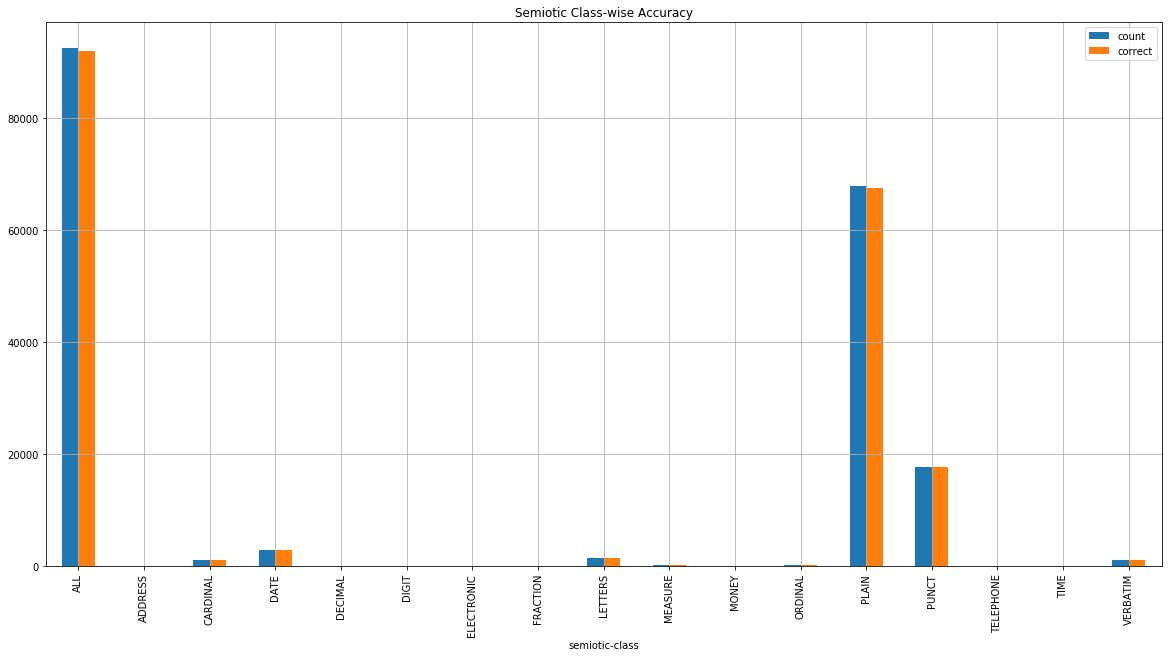

In [17]:
class_accuracy.plot(title='Semiotic Class-wise Accuracy',
                    y=['count', 'correct'], x='semiotic-class',
                    kind='bar', figsize=(20,10), grid=True)
plt.savefig(result_dir+'Semiotic_Class-wise_Accuracy.png')

In [18]:
class_accuracy.to_csv(result_dir+'classwise_accuracy.csv', index=None)

**Normalization Mistakes**

In [19]:
mistake_mask = (results['after'] != truth['after'])
mistakes = results[mistake_mask]
mistakes = mistakes.assign(truth = truth.loc[mistake_mask, 'after'])

In [20]:
mistakes[mistakes['semiotic']=='TIME']

,sentence_id,token_id,semiotic,before,class,after,truth
88069,7196,10,TIME,18:00:00Z,ToBeNormalized,eighteen hours u seconds,eighteen hours zero minutes and zero seconds z
88776,7250,3,TIME,0:02:01,ToBeNormalized,zero hours two minutes and one seconds,zero hours two minutes and one second


**Class-wise mistakes**

In [21]:
mistakes_grouped = mistakes.groupby('semiotic')

In [22]:
mistakes_grouped.apply(lambda x: x.sample(n=3, replace=True))

sentence_id  token_id    semiotic  \
semiotic                                              
CARDINAL   82909         6777         3    CARDINAL   
           2635           205        12    CARDINAL   
           69063         5683         3    CARDINAL   
DATE       74689         6123         5        DATE   
           88533         7230        16        DATE   
           18901         1520         7        DATE   
DECIMAL    71203         5851         5     DECIMAL   
           71203         5851         5     DECIMAL   
           71203         5851         5     DECIMAL   
DIGIT      8563           687         0       DIGIT   
           59585         4895        12       DIGIT   
           59585         4895        12       DIGIT   
ELECTRONIC 56002         4601         2  ELECTRONIC   
           13932         1117        15  ELECTRONIC   
           32861         2701         1  ELECTRONIC   
FRACTION   70920         5828         2    FRACTION   
           71394         5865         3    FRACTION   
           5633           455         3    FRACTION   
LETTERS    87808         7180         9     LETTERS   
           24577         1983        17     LETTERS   
           87030         7113         4     LETTERS   
MEASURE    49134         4039        18     MEASURE   
           49134         4039        18     MEASURE   
           2023           156         3     MEASURE   
MONEY      21543         1726        11       MONEY   
           21543         1726        11       MONEY   
           21543         1726        11       MONEY   
ORDINAL    84918         6945         1     ORDINAL   
           84918         6945         1     ORDINAL   
           74192         6079        10     ORDINAL   
PLAIN      74610         6115         6       PLAIN   
           84834         6938         5       PLAIN   
           41811         3407         7       PLAIN   
PUNCT      86845         7099         0       PUNCT   
           33756         2781         9       PUNCT   
           59444         4885         5       PUNCT   
TELEPHONE  9474           754        11   TELEPHONE   
           9474           754        11   TELEPHONE   
           51054         4189         6   TELEPHONE   
TIME       88069         7196        10        TIME   
           88776         7250         3        TIME   
           88069         7196        10        TIME   
VERBATIM   43455         3555         9    VERBATIM   
           29989         2454         4    VERBATIM   
           30526         2505         3    VERBATIM   

                                                             before  \
semiotic                                                              
CARDINAL   82909                                                  V   
           2635                                          1572225424   
           69063                                          310780751   
DATE       74689                                               2010   
           88533                                               1968   
           18901                                               2016   
DECIMAL    71203                                               .763   
           71203                                               .763   
           71203                                               .763   
DIGIT      8563                                                2007   
           59585                                               1271   
           59585                                               1271   
ELECTRONIC 56002  www.cdc.gov/HealthyYouth/shpps/2006/factsheets...   
           13932  //web.archive.org/web/20110105051516/http://ww...   
           32861  http://www.business-humanrights.org/Links/Repo...   
FRACTION   70920                                            -133/94   
           71394                                                  ⅞   
           5633                                          10/618,543   
LETTERS    8

In [53]:
mistakes.to_csv(result_dir+'mistakes.csv', index=None)

## 9. Comparison
<a id="comparison"></a>

In [23]:
base = pd.read_csv('../results/base-paper_classwise_accuracy.csv')
base

,Semiotic Class,En Count,En Accuracy,Ru Count,Ru Accuracy
0,ALL,92416.0,0.997,93184,0.993
1,PLAIN,68029.0,0.998,60747,0.999
2,PUNCT,17726.0,1.000,20263,1.000
3,DATE,2808.0,0.999,1495,0.976
4,TRANS,NaN,NaN,4103,0.921
5,LETTERS,1404.0,0.971,1839,0.991
6,CARDINAL,1067.0,0.989,2387,0.940
7,VERBATIM,894.0,0.980,1298,1.000
8,MEASURE,142.0,0.986,409,0.883
9,ORDINAL,103.0,0.971,427,0.956


In [24]:
en_accuracy = pd.read_csv('../results/english/classwise_accuracy.csv')
en_accuracy

,semiotic-class,accuracy,count,correct
0,ALL,0.994267,92451,91921
1,ADDRESS,1.000000,4,4
2,CARDINAL,0.994214,1037,1031
3,DATE,0.997175,2832,2824
4,DECIMAL,0.989130,92,91
5,DIGIT,0.795455,44,35
6,ELECTRONIC,0.734694,49,36
7,FRACTION,0.687500,16,11
8,LETTERS,0.971611,1409,1369
9,MEASURE,0.971831,142,138


In [25]:
ru_accuracy = pd.read_csv('../results/russian/classwise_accuracy.csv')
ru_accuracy

,semiotic-class,accuracy,count,correct
0,ALL,0.992875,93196,92532
1,CARDINAL,0.941792,2388,2249
2,DATE,0.973244,1495,1455
3,DECIMAL,0.900000,60,54
4,DIGIT,1.000000,16,16
5,ELECTRONIC,0.604167,48,29
6,FRACTION,0.608696,23,14
7,LETTERS,0.990761,1840,1823
8,MEASURE,0.897810,411,369
9,MONEY,0.894737,19,17


In [26]:
en_base = pd.DataFrame(columns=['semiotic-class', 'base accuracy', 'base count'])
en_base['semiotic-class'] = base['Semiotic Class']
en_base['base accuracy'] = base[' En Accuracy']
en_base['base count'] = base[' En Count']

In [27]:
ru_base = pd.DataFrame(columns=['semiotic-class', 'base accuracy', 'base count'])
ru_base['semiotic-class'] = base['Semiotic Class']
ru_base['base accuracy'] = base[' Ru Accuracy']
ru_base['base count'] = base[' Ru Count']

In [28]:
en_compared = pd.merge(en_base, en_accuracy, on='semiotic-class')
en_compared[['semiotic-class', 'accuracy', 'base accuracy', 'count', 'base count']]

,semiotic-class,accuracy,base accuracy,count,base count
0,ALL,0.994267,0.997,92451,92416.0
1,PLAIN,0.993961,0.998,67894,68029.0
2,PUNCT,0.998873,1.000,17746,17726.0
3,DATE,0.997175,0.999,2832,2808.0
4,LETTERS,0.971611,0.971,1409,1404.0
5,CARDINAL,0.994214,0.989,1037,1067.0
6,VERBATIM,0.994006,0.980,1001,894.0
7,MEASURE,0.971831,0.986,142,142.0
8,ORDINAL,0.980583,0.971,103,103.0
9,DECIMAL,0.989130,1.000,92,89.0


In [29]:
ru_compared = pd.merge(ru_base, ru_accuracy, on='semiotic-class')
ru_compared[['semiotic-class', 'accuracy', 'base accuracy', 'count', 'base count']]

,semiotic-class,accuracy,base accuracy,count,base count
0,ALL,0.992875,0.993,93196,93184
1,PLAIN,0.994688,0.999,64764,60747
2,PUNCT,0.999852,1.000,20264,20263
3,DATE,0.973244,0.976,1495,1495
4,LETTERS,0.990761,0.991,1840,1839
5,CARDINAL,0.941792,0.940,2388,2387
6,VERBATIM,0.998512,1.000,1344,1298
7,MEASURE,0.897810,0.883,411,409
8,ORDINAL,0.946136,0.956,427,427
9,DECIMAL,0.900000,0.867,60,60


**Latex Output**

In [32]:
en_compared

,semiotic-class,base accuracy,base count,accuracy,count,correct
0,ALL,0.997,92416.0,0.994267,92451,91921
1,PLAIN,0.998,68029.0,0.993961,67894,67484
2,PUNCT,1.000,17726.0,0.998873,17746,17726
3,DATE,0.999,2808.0,0.997175,2832,2824
4,LETTERS,0.971,1404.0,0.971611,1409,1369
5,CARDINAL,0.989,1067.0,0.994214,1037,1031
6,VERBATIM,0.980,894.0,0.994006,1001,995
7,MEASURE,0.986,142.0,0.971831,142,138
8,ORDINAL,0.971,103.0,0.980583,103,101
9,DECIMAL,1.000,89.0,0.989130,92,91


In [30]:
print(en_compared[['semiotic-class', 'base count','count','base accuracy','accuracy']].to_latex())

\begin{tabular}{llrrrr}
\toprule
{} & semiotic-class &  base count &  count &  base accuracy &  accuracy \\
\midrule
0  &            ALL &     92416.0 &  92451 &          0.997 &  0.994267 \\
1  &          PLAIN &     68029.0 &  67894 &          0.998 &  0.993961 \\
2  &          PUNCT &     17726.0 &  17746 &          1.000 &  0.998873 \\
3  &           DATE &      2808.0 &   2832 &          0.999 &  0.997175 \\
4  &        LETTERS &      1404.0 &   1409 &          0.971 &  0.971611 \\
5  &       CARDINAL &      1067.0 &   1037 &          0.989 &  0.994214 \\
6  &       VERBATIM &       894.0 &   1001 &          0.980 &  0.994006 \\
7  &        MEASURE &       142.0 &    142 &          0.986 &  0.971831 \\
8  &        ORDINAL &       103.0 &    103 &          0.971 &  0.980583 \\
9  &        DECIMAL &        89.0 &     92 &          1.000 &  0.989130 \\
10 &     ELECTRONIC &        21.0 &     49 &          1.000 &  0.734694 \\
11 &          DIGIT &        37.0 &     44 &          0.86

In [31]:
print(ru_compared[['semiotic-class', 'base count','count','base accuracy','accuracy']].to_latex())

\begin{tabular}{llrrrr}
\toprule
{} & semiotic-class &  base count &  count &  base accuracy &  accuracy \\
\midrule
0  &            ALL &       93184 &  93196 &          0.993 &  0.992875 \\
1  &          PLAIN &       60747 &  64764 &          0.999 &  0.994688 \\
2  &          PUNCT &       20263 &  20264 &          1.000 &  0.999852 \\
3  &           DATE &        1495 &   1495 &          0.976 &  0.973244 \\
4  &        LETTERS &        1839 &   1840 &          0.991 &  0.990761 \\
5  &       CARDINAL &        2387 &   2388 &          0.940 &  0.941792 \\
6  &       VERBATIM &        1298 &   1344 &          1.000 &  0.998512 \\
7  &        MEASURE &         409 &    411 &          0.883 &  0.897810 \\
8  &        ORDINAL &         427 &    427 &          0.956 &  0.946136 \\
9  &        DECIMAL &          60 &     60 &          0.867 &  0.900000 \\
10 &     ELECTRONIC &           2 &     48 &          1.000 &  0.604167 \\
11 &          DIGIT &          16 &     16 &          1.00

## 10. Conclusion
<a id="conclusion"></a>

**English Normalization Accuracy: 99.4% **

**Russian Normalization Accuracy: 99.3% **

___